# Convolutional Nerual Network (CNN) Training
##### Maxwell Rosenzweig

In [74]:
import tensorflow as tf

from tensorflow.keras import *
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner

In [75]:
# Verify tensorflow install
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

2.10.1
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and format testing data

In [76]:
# Load training data
spect_train = np.load('../data/spect_train.npy', allow_pickle=True)
acc_train = np.load('../data/downsampled_acc_train.npy', allow_pickle=True)

In [77]:
# Reshape Training data
# Align the spectograms and acc data
# We skip the first 10 samples to get stable LFP data

stacked = np.stack(acc_train[0]).transpose()
spect_train_concat = spect_train[0][0:min(len(spect_train[0]), len(stacked))-1:]
acc_train_concat = stacked[0:min(len(spect_train[0]), len(stacked))-1:]
for i in range(1, len(spect_train)):
    # print(f'Dataset {i} has {len(spect_train[i])} inputs and {len(np.stack(acc_train[i]).transpose())} outputs')
    # print(f'acc shape is {np.shape(np.stack(acc_train[i]))}')
    stacked = np.stack(acc_train[i]).transpose()
    new_spect = spect_train[i][0:min(len(spect_train[i]), len(stacked))-1:]
    stacked = stacked[0:min(len(spect_train[i]), len(stacked))-1:]
    # throw out any data with outliers or too few data points
    if (len(new_spect) == 0):
        print(f'Dataset {i} has only {len(spect_train[i])} inputs and {len(acc_train[i].transpose())} outputs')
    elif (np.amax(new_spect) > 2e-6):
        print(f'Dataset {i} contains an outlier.')
    else:
        spect_train_concat = np.concatenate((spect_train_concat, new_spect))
        acc_train_concat = np.concatenate((acc_train_concat, stacked))

spect_train1 = spect_train_concat[...,0]
spect_train2 = spect_train_concat[...,1]

# Bring values to near [0,1.0] range
spect_train1 = (spect_train1 * 5e5)
spect_train2 = (spect_train2 * 5e5)

print(np.shape(spect_train1))
print(np.shape(spect_train2))
print(np.shape(acc_train_concat))


(872, 51, 46)
(872, 51, 46)
(872, 3)


In [78]:
#Sanity checks

print(np.median(spect_train1), np.amax(spect_train1), np.amin(spect_train1), np.std(spect_train1))
print(np.median(spect_train2), np.amax(spect_train2), np.amin(spect_train2), np.std(spect_train2))
print(np.median(acc_train_concat), np.amax(acc_train_concat), np.amin(acc_train_concat), np.std(acc_train_concat))

assert not np.any(np.isnan(spect_train1))
assert not np.any(np.isnan(spect_train2))
assert not np.any(np.isnan(acc_train_concat))

0.0069699135063475415 0.6329245918677245 4.770827684969828e-17 0.020502600540949503
0.006569432434188793 0.9434693924351326 3.434788154623767e-14 0.017891566127732354
0.5597014844293868 1.0057527484509179 -0.022734159552087897 0.24253063527187393


In [79]:
import gc

# Free up memory from raw inputs
del spect_train
del acc_train
gc.collect()

KeyboardInterrupt: 

### Define the Model

In [173]:
channel1 = Input(shape=(51, 46, 1))
channel2 = Input(shape=(51, 46, 1))

# cnn2 = layers.Dropout(0.1)(channel2)
# cnn2 = layers.Conv2D(filters=32, kernel_size=(1,46), activation='relu', kernel_regularizer=regularizers.L2(1e-4))(cnn2)
# cnn2 = layers.Conv2D(filters=32, kernel_size=(5,1), activation='relu', kernel_regularizer=regularizers.L2(1e-4))(cnn2)
# cnn2 = layers.MaxPool2D(pool_size=(2,1))(cnn2)
# cnn2 = layers.Dropout(0.1)(cnn2)
# cnn2 = layers.Conv2D(filters=32, kernel_size=(5,1), activation='relu', kernel_regularizer=regularizers.L2(1e-4))(cnn2)
# cnn2 = layers.MaxPool2D(pool_size=(2,1))(cnn2)
# cnn2 = layers.Dropout(0.1)(cnn2)
# cnn2 = layers.Flatten()(cnn2)

cnn1 = layers.Conv2D(filters=16, kernel_size=(1,46), activation='relu')(channel1)
cnn1 = layers.Conv2D(filters=32, kernel_size=(3,1), activation='relu')(cnn1)
cnn1 = layers.MaxPool2D(pool_size=(2,1))(cnn1)
cnn1 = layers.Conv2D(filters=32, kernel_size=(3,1), activation='relu')(cnn1)
cnn1 = layers.Dropout(0.2)(cnn1)
cnn1 = layers.Flatten()(cnn1)

cnn2 = layers.Conv2D(filters=16, kernel_size=(1,46), activation='relu')(channel2)
cnn2 = layers.Conv2D(filters=32, kernel_size=(3,1), activation='relu')(cnn2)
cnn2 = layers.MaxPool2D(pool_size=(2,1))(cnn2)
cnn2 = layers.Conv2D(filters=32, kernel_size=(3,1), activation='relu')(cnn2)
cnn2 = layers.Dropout(0.2)(cnn2)
cnn2 = layers.Flatten()(cnn2)


output = layers.concatenate([cnn1, cnn2])
output = layers.Dense(512, activation='relu')(output)
output = layers.Dropout(0.4)(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.Dropout(0.4)(output)
output = layers.Dense(128, activation='relu')(output)
utput = layers.Dropout(0.4)(output)
# output = layers.Dense(256, activation='relu'ctivation='relu')(output)
# output = layers.Dropout(0.4)(output)
output = layers.Dense(3)(output)

model = models.Model(inputs=[channel1, channel2], outputs=output)
opt = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse')

model.summary()


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 51, 46, 1)]  0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 51, 46, 1)]  0           []                               
                                                                                                  
 conv2d_184 (Conv2D)            (None, 51, 1, 16)    752         ['input_65[0][0]']               
                                                                                                  
 conv2d_187 (Conv2D)            (None, 51, 1, 16)    752         ['input_66[0][0]']               
                                                                                           

### Fit model

In [174]:
from datetime import *

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

checkpoint = tf.keras.callbacks.ModelCheckpoint('modelbest{epoch}.h5', save_freq=1000)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(
    (spect_train1, spect_train2),
    acc_train_concat,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint, earlystop, tboard_callback],
    validation_data=((spect_val1, spect_val2), acc_val_concat),
    shuffle=True
)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Epoch 1/100
28/28 [==============================] - 2s 27ms/step - loss: 0.1101 - val_loss: 0.0592
Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0615 - val_loss: 0.0585
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0613 - val_loss: 0.0635
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0597 - val_loss: 0.0591
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0623 - val_loss: 0.0574
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0596 - val_loss: 0.0608
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0596 - val_loss: 0.0590
Epoch 8/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0600 - val_loss: 0.0592
Epoch 9/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0593 - val_loss: 0.0578
Epoch 10/100
28/28 [========

Text(0.5, 1.0, 'Model error')

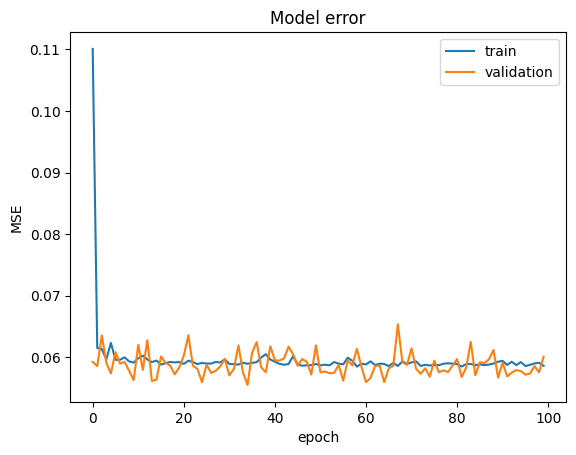

In [176]:

plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.title('Model error')

### Test Model

In [138]:
# Load testing data
spect_test = np.load('../data/spect_test.npy', allow_pickle=True)
acc_test = np.load('../data/downsampled_acc_test.npy', allow_pickle=True)

In [139]:
# Reshape testing data
# Throw away first 7 acc values; these correspond to the data points before 400ms

stacked = np.stack(acc_test[0]).transpose()
spect_test_concat = spect_test[0][:min(len(spect_test[0]), len(stacked))-1:]
acc_test_concat = stacked[:min(len(spect_test[0]), len(stacked))-1:]
for i in range(1, len(spect_test)):
    # print(f'Dataset {i} has {len(spect_test[i])} inputs and {len(np.stack(acc_test[i]).transpose())} outputs')
    # print(f'acc shape is {np.shape(np.stack(acc_test[i]))}')
    stacked = np.stack(acc_test[i]).transpose()
    new_spect = spect_test[i][:min(len(spect_test[i]), len(stacked))-1:]
    stacked = stacked[:min(len(spect_test[i]), len(stacked))-1:]
    # throw out any data with outliers or too few data points
    if (len(new_spect) == 0):
        print(f'Dataset {i} has only {len(spect_test[i])} inputs and {len(acc_test[i].transpose())} outputs')
    elif (np.amax(new_spect) > 2e-6):
        print(f'Dataset {i} contains an outlier.')
    else:
        spect_test_concat = np.concatenate((spect_test_concat, new_spect))
        acc_test_concat = np.concatenate((acc_test_concat, stacked))

spect_test1 = spect_test_concat[...,0]
spect_test2 = spect_test_concat[...,1]
spect_test1 = (spect_test1 * 5e5)
spect_test2 = (spect_test2 * 5e5)

[spect_test1, spect_val1] = np.array_split(spect_test1, 2)
[spect_test2, spect_val2] = np.array_split(spect_test2, 2)
[acc_test_concat, acc_val_concat] = np.array_split(acc_test_concat, 2)
print(np.shape(spect_test1))
print(np.shape(spect_val1))
print(np.shape(spect_test2))
print(np.shape(spect_val2))
print(np.shape(acc_test_concat))
print(np.shape(acc_val_concat))

Dataset 3 contains an outlier.
(54, 51, 46)
(53, 51, 46)
(54, 51, 46)
(53, 51, 46)
(54, 3)
(53, 3)


In [ ]:
#Sanity checks

print(np.median(spect_test1), np.amax(spect_test1), np.amin(spect_test1), np.std(spect_test1))
print(np.median(spect_test2), np.amax(spect_test2), np.amin(spect_test2), np.std(spect_test2))
print(np.median(acc_test_concat), np.amax(acc_test_concat), np.amin(acc_test_concat), np.std(acc_test_concat))

assert not np.any(np.isnan(spect_test1))
assert not np.any(np.isnan(spect_test2))
assert not np.any(np.isnan(acc_test_concat))

0.007329844324219412 0.2886166688900546 4.607584259614769e-11 0.019042623162691993
0.006626738044768712 0.2445288793304872 3.935434253822601e-11 0.015773987103624744
0.5386125114071327 0.9800837445949518 0.014439382838516987 0.22811002183500792


In [ ]:
import gc

# Free up memory from raw inputs
del spect_test
del acc_test
gc.collect()

27284

In [165]:
model = models.load_model('modelbest20.h5')
print(model.weights)

[<tf.Variable 'conv2d_207/kernel:0' shape=(1, 46, 1, 16) dtype=float32, numpy=
array([[[[-3.06902081e-02,  2.67075747e-02,  9.16732401e-02,
           6.12784959e-02,  3.85852307e-02, -7.60580674e-02,
           4.49075922e-02, -4.02022712e-02,  6.96178600e-02,
           9.11002606e-02, -6.79386035e-03,  7.93105364e-02,
          -5.76813370e-02,  4.77707461e-02,  1.04314581e-01,
           3.80232520e-02]],

        [[-5.68729863e-02,  1.88273937e-02,  9.15607437e-03,
          -1.78683605e-02,  9.79990065e-02,  8.16168264e-02,
          -3.73069569e-03, -1.91103958e-04,  8.71405602e-02,
           7.23499507e-02, -7.36360252e-03, -1.80215873e-02,
           6.84659854e-02, -3.25668454e-02,  2.05180030e-02,
          -3.67479287e-02]],

        [[-1.44566158e-02, -1.40191731e-03,  9.41566564e-03,
           4.04233821e-02,  7.52787367e-02,  3.14045884e-02,
          -8.89851153e-02, -5.64035550e-02,  1.30114127e-02,
           4.72294278e-02, -8.22001323e-02, -4.06656004e-02,
       

In [181]:
print(model.weights)
model.evaluate((spect_test1, spect_test2), acc_test_concat, batch_size=256)
prediciton = model.predict((spect_test1, spect_test2))
print(prediciton)

[<tf.Variable 'conv2d_184/kernel:0' shape=(1, 46, 1, 16) dtype=float32, numpy=
array([[[[ 3.37183778e-03,  2.32955650e-03,  6.26730919e-02,
           5.82025312e-02,  4.60649654e-02,  1.24967266e-02,
          -6.36408478e-02, -6.97117150e-02, -5.63752875e-02,
           4.09603342e-02, -2.92378310e-02, -5.36988378e-02,
          -8.22717994e-02, -5.54643869e-02, -1.80617417e-03,
          -1.03736371e-01]],

        [[-3.55807617e-02, -7.93122351e-02,  1.94651280e-02,
           2.67584417e-02, -4.52548526e-02, -1.10178450e-02,
           1.75227467e-02, -2.55150530e-06,  1.79323591e-02,
          -1.13993570e-01, -7.98527598e-02, -5.76020405e-02,
           3.15857120e-02,  5.22277504e-02, -4.33715992e-02,
           8.26063659e-03]],

        [[ 2.06228439e-02, -1.11909471e-01, -4.76006828e-02,
          -9.66786295e-02, -5.13118634e-04, -1.73083637e-02,
          -8.86187255e-02,  1.92295350e-02, -1.29792690e-01,
           1.14405202e-02, -4.67506126e-02, -3.11655849e-02,
       

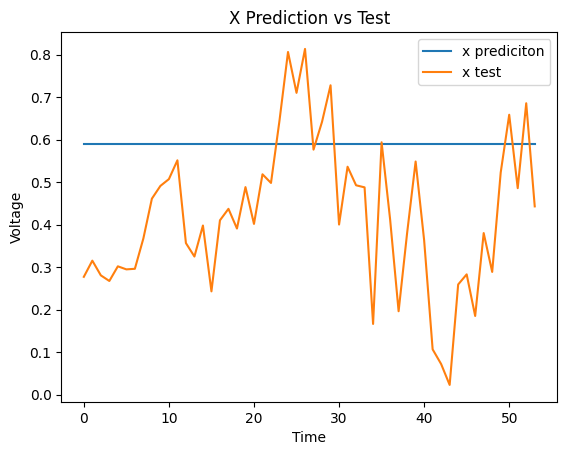

In [183]:
prediction = np.array(prediciton)

data_x_test = acc_test_concat.T[0]
data_x_pred = prediction[...,0]

# display contents
plt.plot(data_x_pred, label='x prediciton')
plt.plot(data_x_test, label='x test')
plt.title("X Prediction vs Test")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

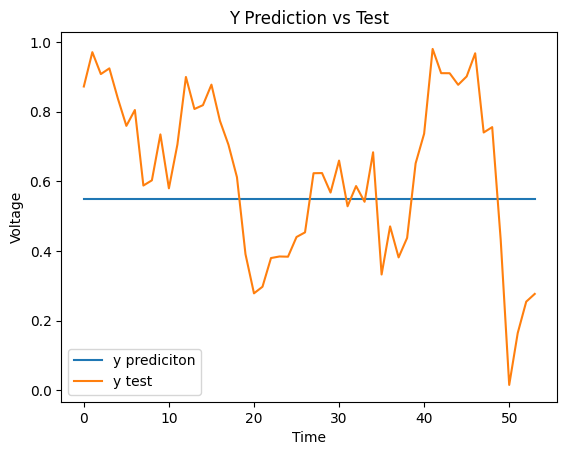

In [184]:

data_y_test = acc_test_concat.T[1]
data_y_pred = prediction[...,1]
plt.plot(data_y_pred, label='y prediciton')
plt.plot(data_y_test, label='y test')
plt.title("Y Prediction vs Test")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

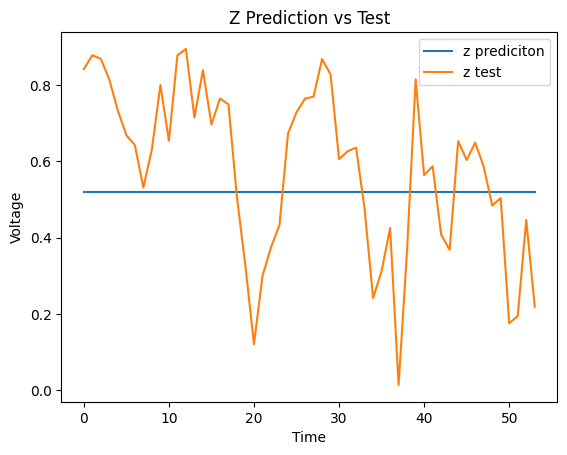

In [185]:

data_z_test = acc_test_concat.T[2]
data_z_pred = prediction[...,2]
plt.plot(data_z_pred, label='z prediciton')
plt.plot(data_z_test, label='z test')
plt.title("Z Prediction vs Test")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

### Tune Hyperparameters
To-do

In [ ]:
# Shuffle training data and split in half to reduce epoch runtime for HP tuning
p = np.random.permutation(len(spect_train1))
[p, _] = np.array_split(p, 2)
spect_train1 = spect_train1[p]
spect_train2 = spect_train2[p]
acc_train_concat = acc_train_concat[p]

In [ ]:
# Same, but for validation data 
p = np.random.permutation(len(spect_val1))
[p, _] = np.array_split(p, 2)
spect_val1 = spect_val1[p]
spect_val2 = spect_val2[p]
acc_val_concat = acc_val_concat[p]

In [ ]:
from datetime import *

def build_model(hp):

    channel1 = Input(shape=(51, 46, 1))
    channel2 = Input(shape=(51, 46, 1))

    input_drop_rate = hp.Float(f'dropout_conv_rate', 0, 0.2, step=0.05, default=0.1)
    cnn1 = layers.Dropout(input_drop_rate)(channel1)
    cnn2 = layers.Dropout(input_drop_rate)(channel2)

    hp_filters = hp.Int('filters_vert', 8, 64, step=8, default=32)
    hp_kernel_size = hp.Int('kernel_size_vert', 3, 46, step=1, default=32)
    cnn1 = layers.Conv2D(filters=hp_filters, kernel_size=(1,hp_kernel_size), activation='relu')(cnn1)
    cnn2 = layers.Conv2D(filters=hp_filters, kernel_size=(1,hp_kernel_size), activation='relu')(cnn2)

    for i in range(hp.Int('conv_layers', 1, 3, default=2)):
        hp_filters = hp.Int(f'filters_{i}', 8, 64, step=8, default=32)
        hp_kernel_size = hp.Int(f'kernel_size_{i}', 3, 5, step=2, default=3)
        cnn1 = layers.Conv2D(
            filters=hp_filters,
            kernel_size=(hp_kernel_size, 1),
            activation='relu',
            padding='same')(cnn1)
        cnn2 = layers.Conv2D(
            filters=hp_filters,
            kernel_size=(hp_kernel_size, 1),
            activation='relu',
            padding='same')(cnn2)
        cnn1 = layers.MaxPooling2D(pool_size=(2,1))(cnn1)
        cnn2 = layers.MaxPooling2D(pool_size=(2,1))(cnn2)

    conv_drop_rate = hp.Float(f'dropout_conv_rate', 0, 0.2, step=0.05, default=0.1)
    cnn1 = layers.Dropout(conv_drop_rate)(cnn1)
    cnn2 = layers.Dropout(conv_drop_rate)(cnn2)
    cnn1 = layers.Flatten()(cnn1)
    cnn2 = layers.Flatten()(cnn2)

    output = layers.concatenate([cnn1, cnn2])
    dense_units = hp.Int(f'dense_units', 64, 768, step=64, default=512)
    dense_drop_rate = hp.Float(f'dropout_dense_rate_{i}', 0, 0.5, step=0.1, default=0.3)
    for i in range(hp.Int('dense_layers', 1, 5, default=3)):
        output = layers.Dense(units=dense_units, activation='relu')(output)
        output = layers.Dropout(dense_drop_rate)(output)
    output = layers.Dense(3)(output)

    model = models.Model(inputs=[channel1, channel2], outputs=output)
    opt = optimizers.Adam(learning_rate=hp.Float('learning_rate',min_value=0.0005, max_value=0.005, sampling='log', default=0.001))
    model.compile(optimizer='adam', loss='mse')

    return model


tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=500,
    objective="val_loss"
)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs)
earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
earlystop_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

tuner.search(
    (spect_train1, spect_train2), acc_train_concat,
    epochs=300,
    validation_data=((spect_val1, spect_val2), acc_val_concat),
    shuffle=True,
    callbacks=[earlystop_loss, earlystop_val_loss, tboard_callback]
)

Trial 367 Complete [00h 01m 02s]
val_loss: 0.008462972939014435

Best val_loss So Far: 0.008326705545186996
Total elapsed time: 05h 05m 03s

Search: Running Trial #368

Value             |Best Value So Far |Hyperparameter
0.15              |0                 |dropout_conv_rate
24                |24                |filters_vert
20                |29                |kernel_size_vert
1                 |3                 |conv_layers
48                |56                |filters_0
5                 |3                 |kernel_size_0
24                |48                |filters_1
5                 |5                 |kernel_size_1
448               |512               |dense_units
0.3               |0.3               |dropout_dense_rate_1
3                 |3                 |dense_layers
0.0014214         |0.0028372         |learning_rate
40                |16                |filters_2
3                 |3                 |kernel_size_2
0.3               |0                 |dropout_dense_ra